## Fast.ai Deep Learning 1 Practice - Pets revisited

This notebook is practice for Lesson 3 of the [Fast.ai](https://www.fast.ai) course. It revisits the themes from the Lesson 2 practice on pets. This time around, it is generating a heatmap overlayed onto an image of a pet to represent what areas had the highest activation in deciding what class that image falls under.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 64

In [3]:
path = Path('/path/to/Datasets/oxford-iiit-pet/images/')

In [4]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                     p_affine=1., p_lighting=1.)

In [5]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [6]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
            .transform(tfms, size=size, padding_mode=padding_mode)
            .databunch(bs=bs).normalize(imagenet_stats))

In [7]:
data = get_data(224, bs, 'zeros')

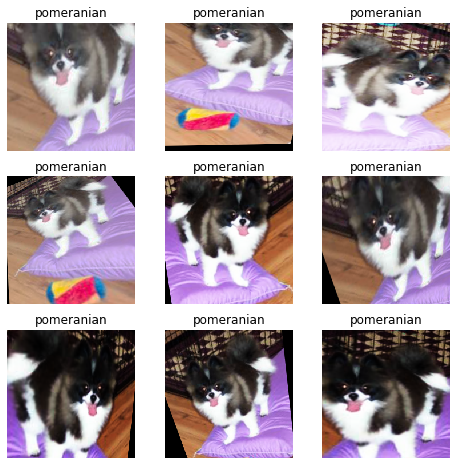

In [8]:
def _plot(i, j, ax):
    x, y = data.train_ds[15]
    x.show(ax, y=y)
    
plot_multi(_plot, 3, 3, figsize=(8, 8))

In [9]:
data = get_data(224, bs)

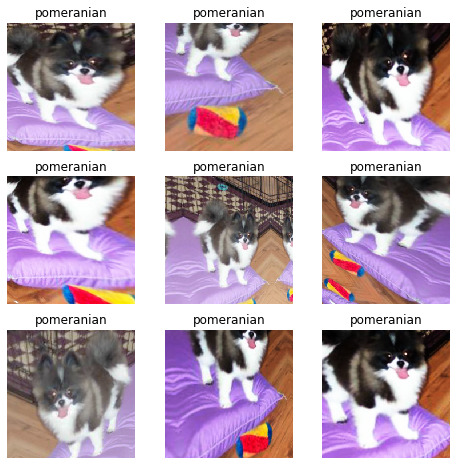

In [10]:
plot_multi(_plot, 3, 3, figsize=(8, 8))

In [11]:
# train the model
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [12]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.637931,0.353678,0.087957,00:22
1,0.980598,0.266167,0.083897,00:19
2,0.720985,0.230879,0.067659,00:18


In [13]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.587319,0.238711,0.062923,00:22
1,0.570774,0.232068,0.065629,00:22


In [14]:
data = get_data(352, bs)
learn.data = data

In [14]:
learn.save('352')

### Convolution Kernel

In [15]:
data = get_data(352, 16)

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category 17

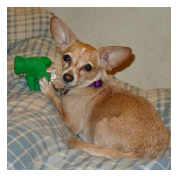

In [17]:
idx = 0
x, y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [18]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [19]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [20]:
k.shape

torch.Size([1, 3, 3, 3])

In [21]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [22]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [23]:
edge = F.conv2d(t[None], k)

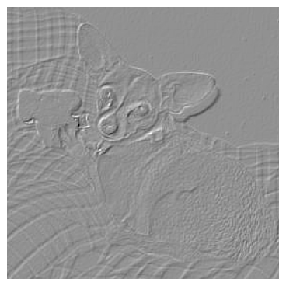

In [24]:
show_image(edge[0], figsize=(5, 5))

In [25]:
data.c

37

In [26]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [27]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

### Heatmap

In [28]:
m = learn.model.eval();

In [29]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [30]:
from fastai.callbacks.hooks import *

In [31]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [32]:
hook_a, hook_g = hooked_backward()

In [33]:
acts = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [34]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [35]:
def show_heatmap(hm):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0, 352, 352, 0),
             interpolation='bilinear', cmap='magma');

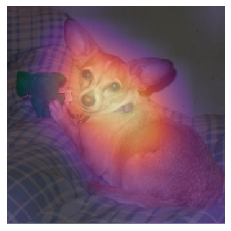

In [36]:
show_heatmap(avg_acts)

### Grad-CAM

In [37]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape, grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [38]:
mult = (acts * grad_chan[..., None, None]).mean(0)

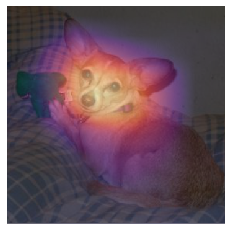

In [39]:
show_heatmap(mult)